# I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. UPLOAD DATA

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.head(10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,2,1,1,0,3,1,0.070366,2,0.716263,1
1,1,3,1,3,0,2,0,0.057496,2,0.598616,0
2,1,2,1,1,0,3,1,0.066347,2,0.058824,1
3,1,1,1,3,1,1,0,0.048348,1,0.667820,0
4,0,1,1,2,1,1,0,0.046259,1,0.100346,0
5,0,1,1,3,0,1,1,0.000000,3,0.574394,0
6,1,1,1,3,0,1,1,0.038578,1,0.826990,0
7,0,2,1,1,0,2,1,0.054696,2,0.214533,1
8,0,1,1,3,1,1,0,0.046488,1,0.062284,0
9,0,1,1,3,1,1,0,0.048631,1,0.242215,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
train.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,1.627461,0.997869,2.156979,0.458210,1.609616,0.504877,0.051193,2.241482,0.499472,0.122563
std,0.498336,0.665683,0.046110,0.831136,0.498251,0.567439,0.499977,0.028791,1.098346,0.289520,0.327936
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.040509,1.000000,0.249135,0.000000
50%,1.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.054023,2.000000,0.498270,0.000000
75%,1.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1.000000,0.068405,3.000000,0.750865,0.000000
max,1.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,0.110249,4.000000,1.000000,1.000000


# III. TRAIN TEST SPLIT RATIO

In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

## 3.1 RandomOverSampling

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử l ý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [ ]:
# Khởi tạo DataFrame để lưu kết quả
results = pd.DataFrame(columns=['Model', 'Ratio', 'Accuracy', 'F1 Score', 'Log Loss', 'AUC', 'TN', 'FP', 'FN', 'TP', 'Execution Time'])

## 3.2 RATIO 50:50

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.5, random_state=42)

### 3.2.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

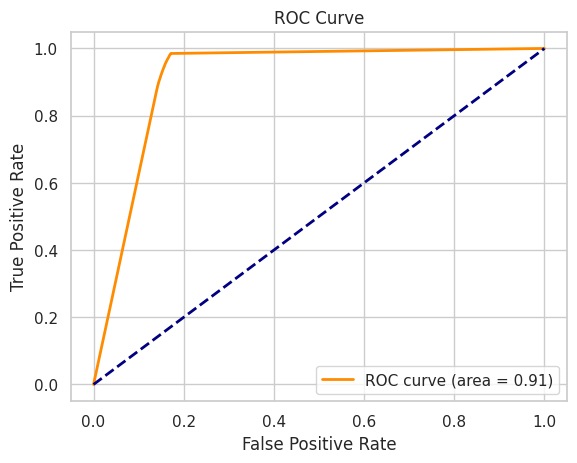

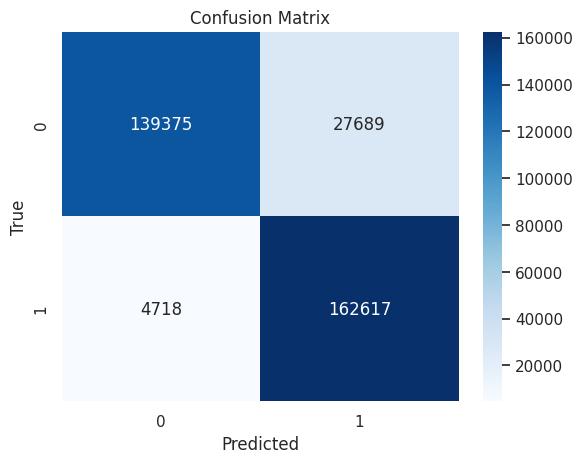

Accuracy: 0.903
F1 Score: 0.903
Log Loss: 2.830
AUC: 0.913
Execution Time: 00:00:03


<ipython-input-22-04d64abe70a4>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results

# Gọi hàm
results = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '50:50', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.931
- F1 Score using DecisionTreeClassifier: 0.931
- Log Loss using DecisionTreeClassifier: 1.885
- AUC using DecisionTreeClassifier: 0.941
- Thời gian thực thi: 00:00:06

### 3.2.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


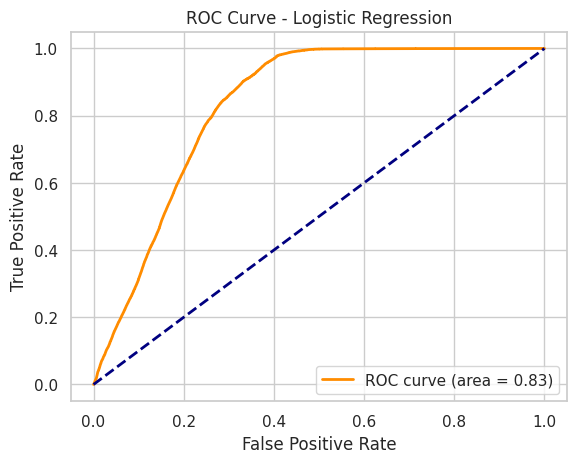

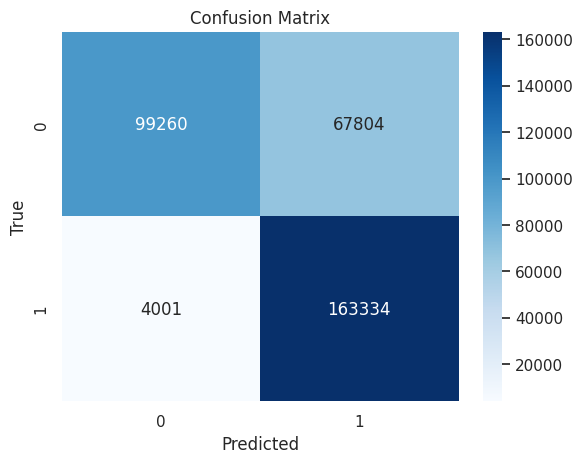

Accuracy using Logistic Regression: 0.785
F1 Score using Logistic Regression: 0.777
Log Loss using Logistic Regression: 0.442
AUC using Logistic Regression: 0.831
Thời gian thực thi: 00:00:08


<ipython-input-24-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '50:50'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.787
- F1 Score using Logistic Regression: 0.781
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.842
- Thời gian thực thi: 00:00:03

### 3.2.3 Bagging Classifier



In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


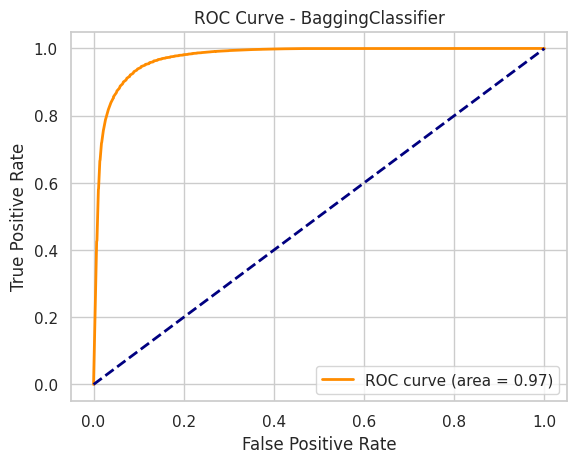

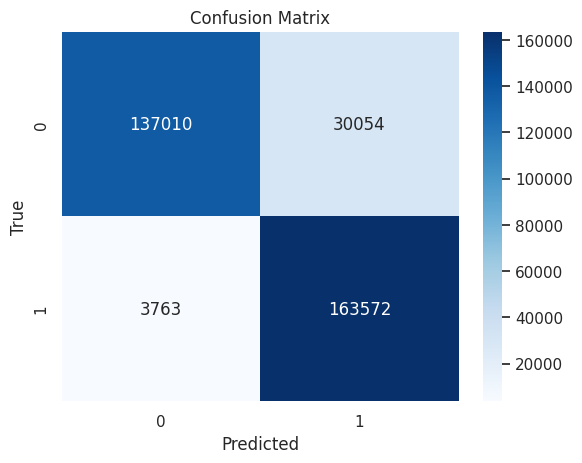

Accuracy using BaggingClassifier: 0.899
F1 Score using BaggingClassifier: 0.898
Log Loss using BaggingClassifier: 0.337
AUC using BaggingClassifier: 0.975
Thời gian thực thi: 00:02:23


<ipython-input-27-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '50:50'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.932
- F1 Score using BaggingClassifier: 0.931
- Log Loss using BaggingClassifier: 0.262
- AUC using BaggingClassifier: 0.989
- Thời gian thực thi: 00:02:52

### 3.2.4. Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


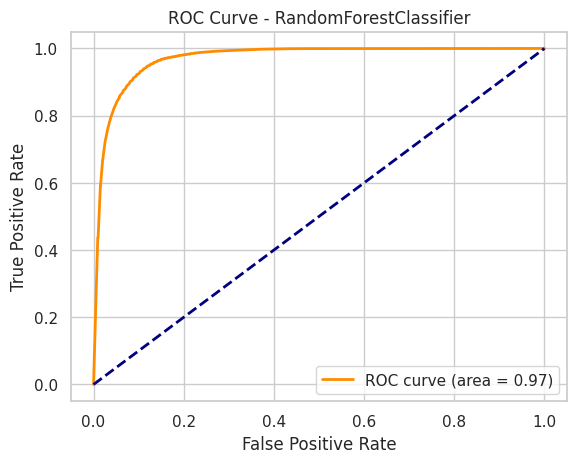

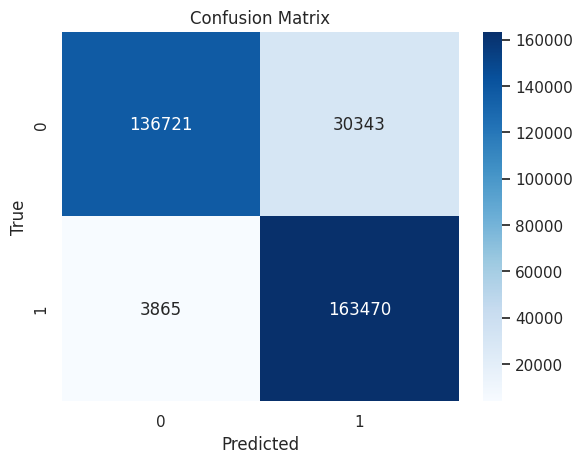

Accuracy using RandomForestClassifier: 0.898
F1 Score using RandomForestClassifier: 0.897
Log Loss using RandomForestClassifier: 0.389
AUC using RandomForestClassifier: 0.970
Thời gian thực thi: 00:00:53


<ipython-input-30-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = "50:50"

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.928
- F1 Score using RandomForestClassifier: 0.928
- Log Loss using RandomForestClassifier: 0.318
- AUC using RandomForestClassifier: 0.985
- Thời gian thực thi: 00:01:05

### 3.2.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


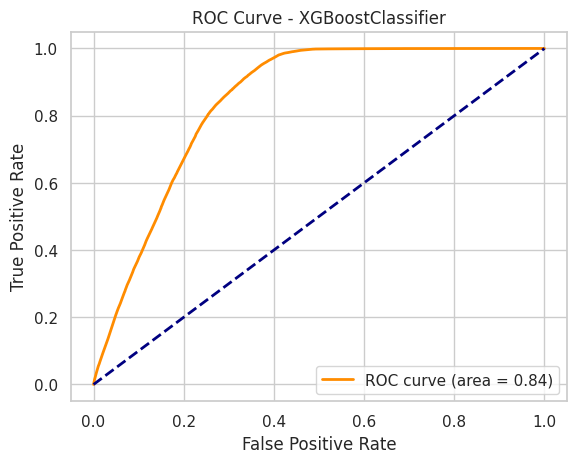

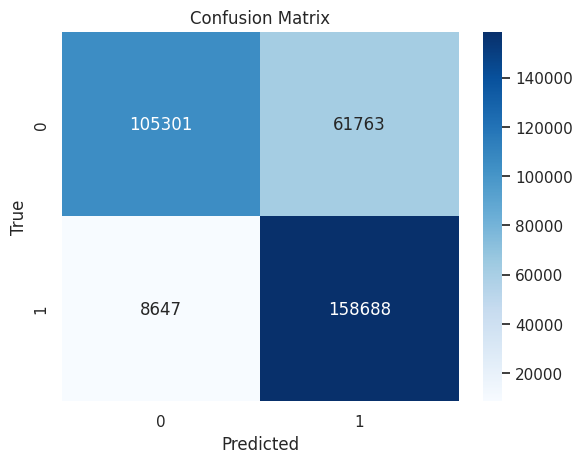

Accuracy using XGBoostClassifier: 0.789
F1 Score using XGBoostClassifier: 0.784
Log Loss using XGBoostClassifier: 0.432
AUC using XGBoostClassifier: 0.843
Thời gian thực thi: 00:00:03


<ipython-input-33-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = "50:50"
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.431
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:06

### 3.2.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


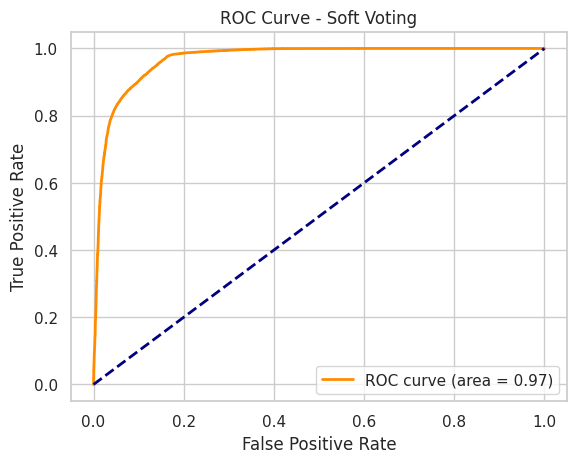

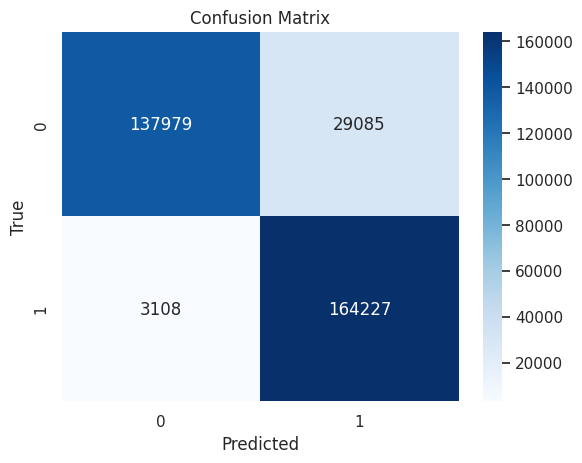

Accuracy using Soft Voting: 0.904
F1 Score using Soft Voting: 0.903
Log Loss using Soft Voting: 0.264
AUC using Soft Voting: 0.968
Thời gian thực thi: 00:01:37


<ipython-input-36-327ea5aea0a5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = "50:50"
# Ensure results DataFrame is initialized
results = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.930
- F1 Score using Soft Voting: 0.930
- Log Loss using Soft Voting: 0.221
- AUC using Soft Voting: 0.982
- Thời gian thực thi: 00:02:50

## 3.3 RATIO 70:30

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.3, random_state=42)

### 3.3.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

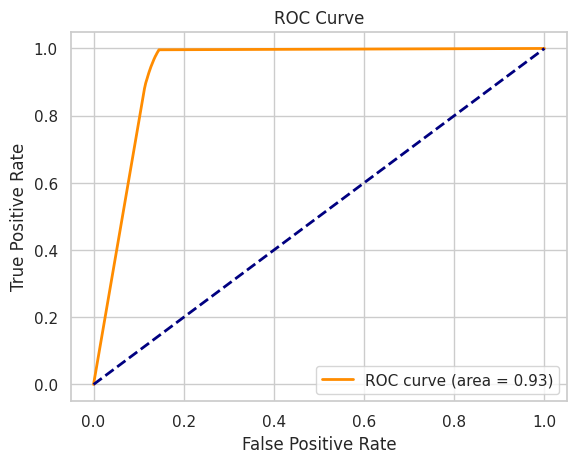

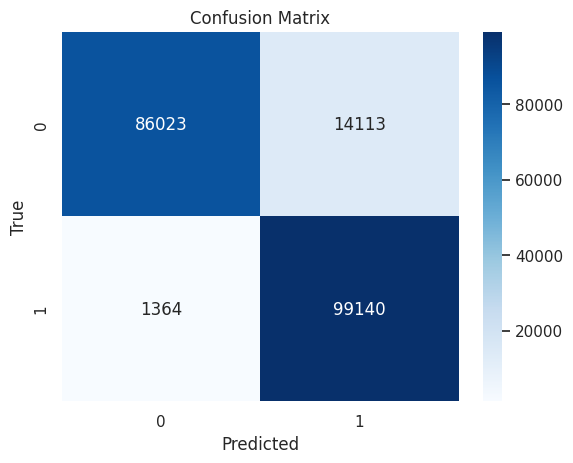

Accuracy: 0.923
F1 Score: 0.923
Log Loss: 2.120
AUC: 0.934
Execution Time: 00:00:04


<ipython-input-42-b214966e2643>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results

# Gọi hàm
results = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '70:30', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.905
- F1 Score using DecisionTreeClassifier: 0.904
- Log Loss using DecisionTreeClassifier: 2.851
- AUC using DecisionTreeClassifier: 0.913
- Thời gian thực thi: 00:00:03

### 3.3.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


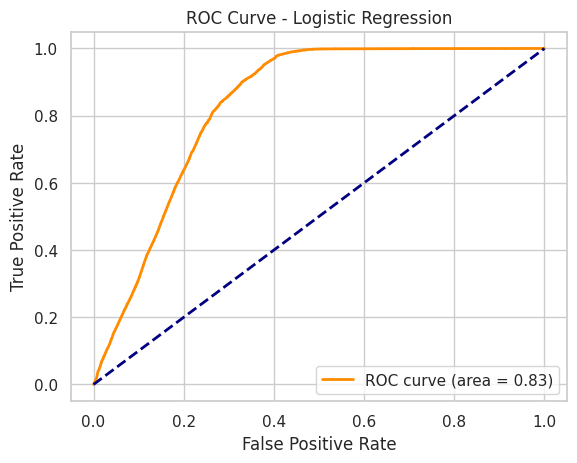

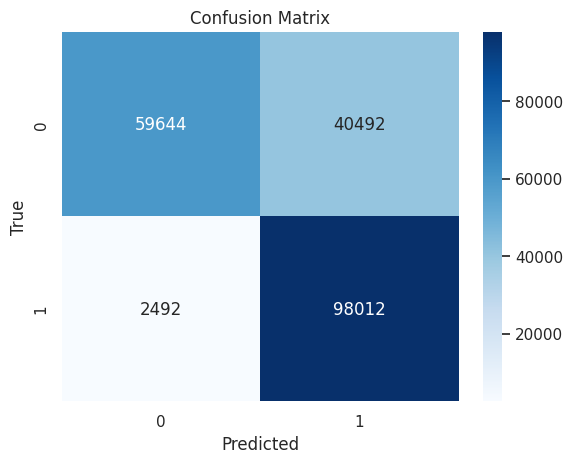

Accuracy using Logistic Regression: 0.786
F1 Score using Logistic Regression: 0.778
Log Loss using Logistic Regression: 0.441
AUC using Logistic Regression: 0.832
Thời gian thực thi: 00:00:06


<ipython-input-44-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '70:30'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.787
- F1 Score using Logistic Regression: 0.782
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.841
- Thời gian thực thi: 00:00:02

### 3.3.3 Bagging Classifier

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


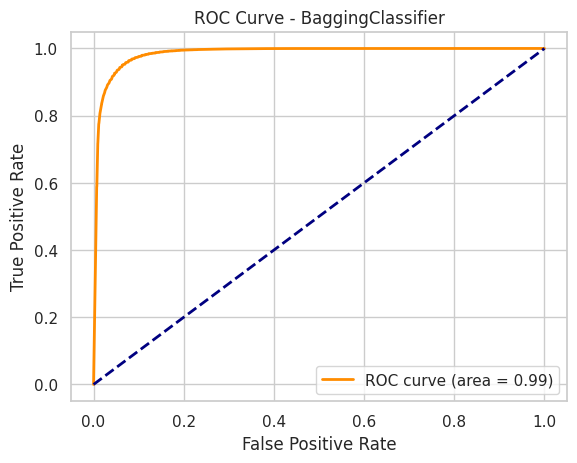

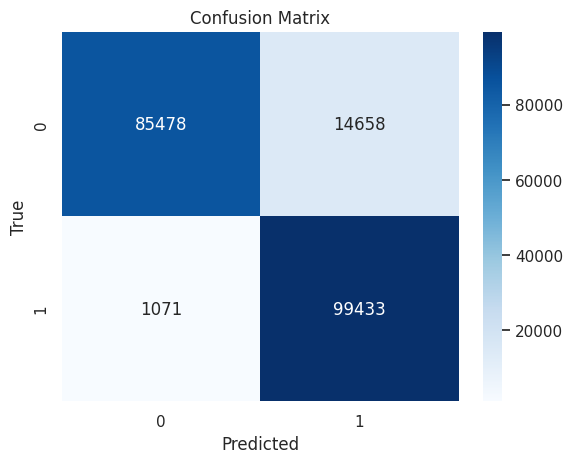

Accuracy using BaggingClassifier: 0.922
F1 Score using BaggingClassifier: 0.921
Log Loss using BaggingClassifier: 0.292
AUC using BaggingClassifier: 0.985
Thời gian thực thi: 00:02:03


<ipython-input-47-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '70:30'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.901
- F1 Score using BaggingClassifier: 0.901
- Log Loss using BaggingClassifier: 0.339
- AUC using BaggingClassifier: 0.976
- Thời gian thực thi: 00:01:45

### 3.3.4 Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


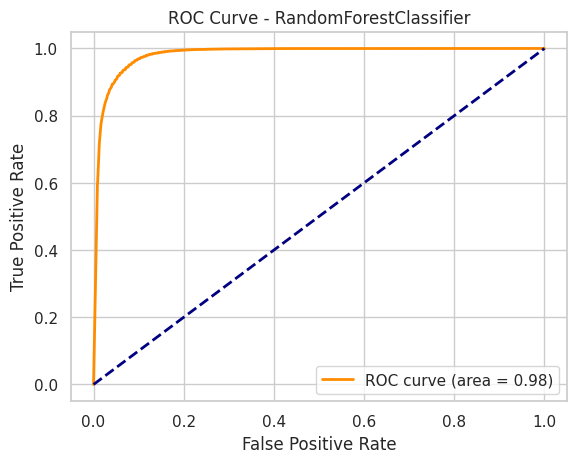

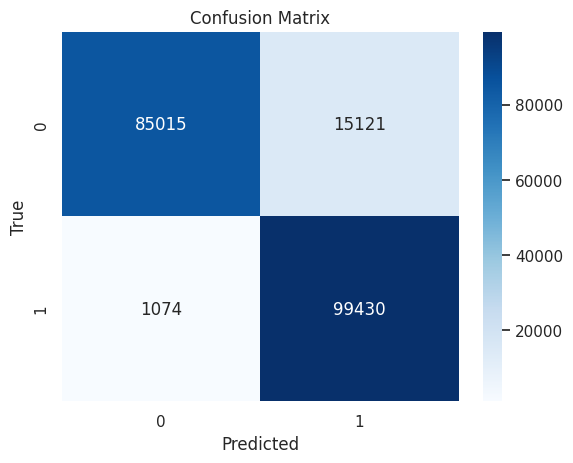

Accuracy using RandomForestClassifier: 0.919
F1 Score using RandomForestClassifier: 0.919
Log Loss using RandomForestClassifier: 0.329
AUC using RandomForestClassifier: 0.982
Thời gian thực thi: 00:00:58


<ipython-input-50-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = "70:30"

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.899
- F1 Score using RandomForestClassifier: 0.899
- Log Loss using RandomForestClassifier: 0.424
- AUC using RandomForestClassifier: 0.969
- Thời gian thực thi: 00:00:43

### 3.3.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


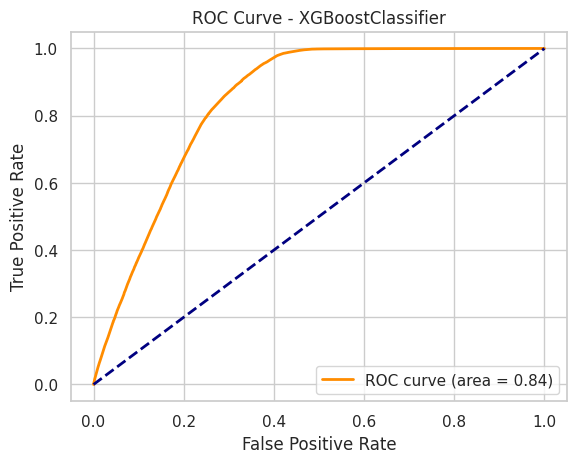

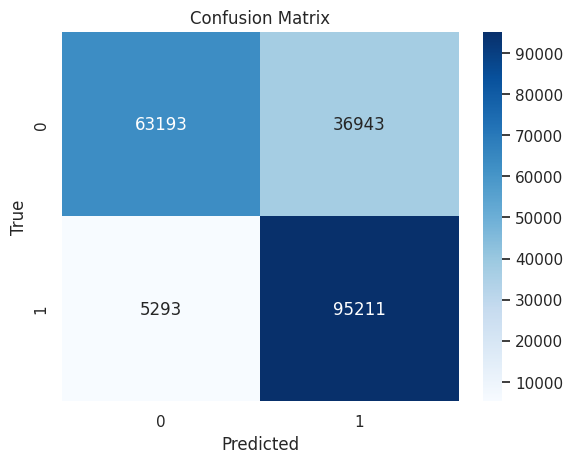

Accuracy using XGBoostClassifier: 0.789
F1 Score using XGBoostClassifier: 0.784
Log Loss using XGBoostClassifier: 0.432
AUC using XGBoostClassifier: 0.843
Thời gian thực thi: 00:00:05


<ipython-input-53-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = "70:30"
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.432
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:04

### 3.3.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


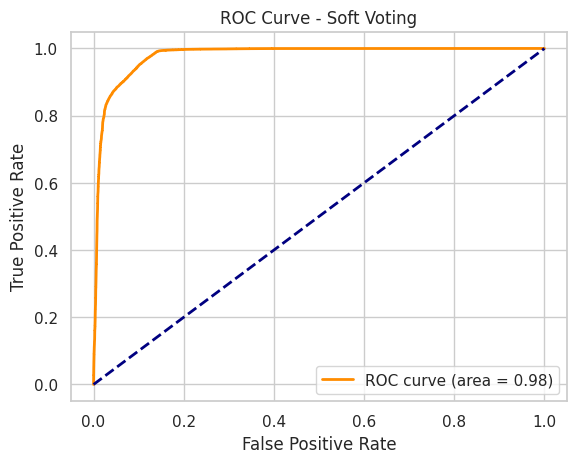

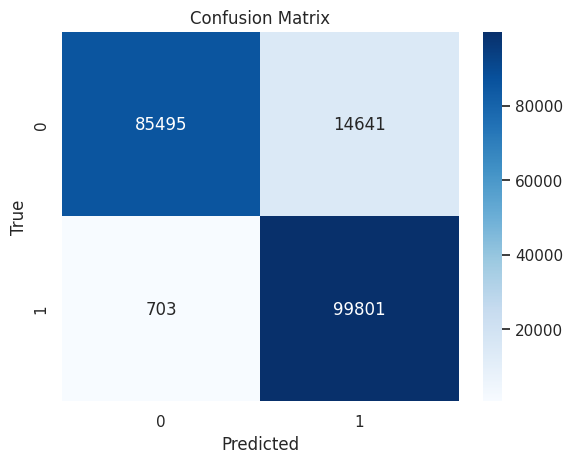

Accuracy using Soft Voting: 0.924
F1 Score using Soft Voting: 0.923
Log Loss using Soft Voting: 0.235
AUC using Soft Voting: 0.979
Thời gian thực thi: 00:02:03


<ipython-input-56-327ea5aea0a5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = "70:30"
# Ensure results DataFrame is initialized
results = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.905
- F1 Score using Soft Voting: 0.904
- Log Loss using Soft Voting: 0.261
- AUC using Soft Voting: 0.968
- Thời gian thực thi: 00:01:46

## 3.4 RATIO 80:20

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

### 3.4.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

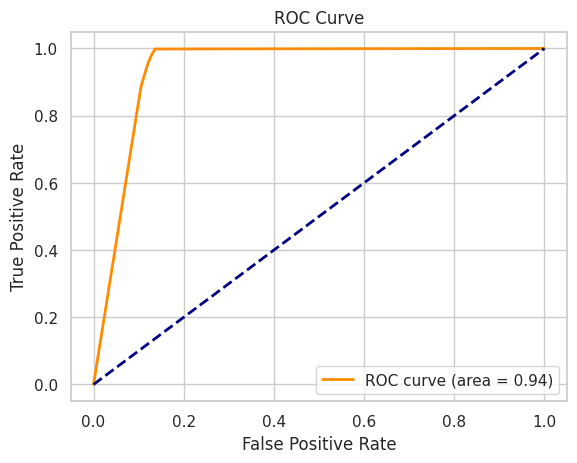

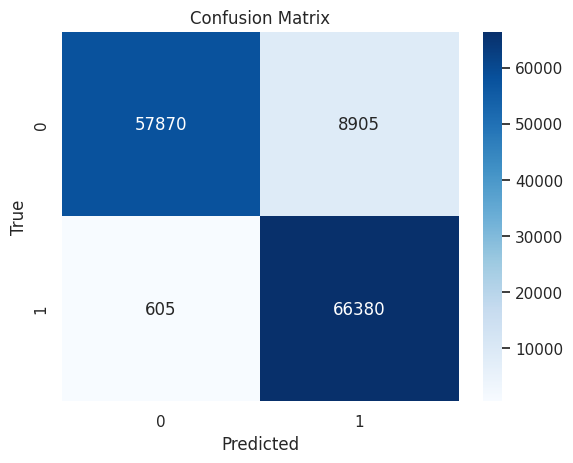

Accuracy: 0.929
F1 Score: 0.929
Log Loss: 1.919
AUC: 0.939
Execution Time: 00:00:04


<ipython-input-62-386eb96747c3>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results, clf

# Gọi hàm
results, clf = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '80:20', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.925
- F1 Score using DecisionTreeClassifier: 0.924
- Log Loss using DecisionTreeClassifier: 2.110
- AUC using DecisionTreeClassifier: 0.934
- Thời gian thực thi: 00:00:03

### 3.4.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


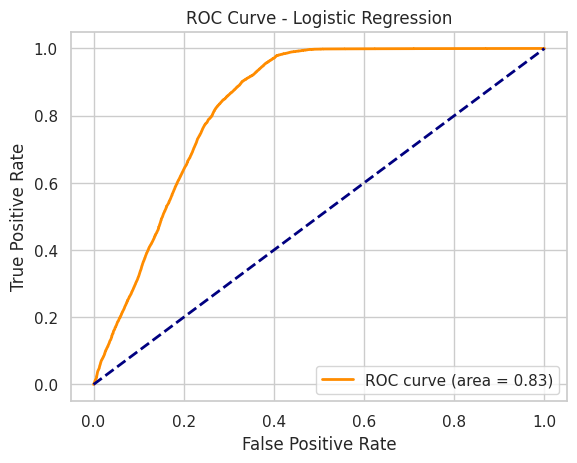

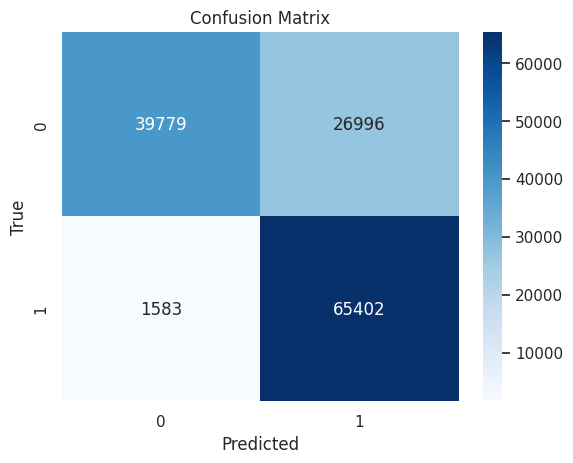

Accuracy using Logistic Regression: 0.786
F1 Score using Logistic Regression: 0.778
Log Loss using Logistic Regression: 0.440
AUC using Logistic Regression: 0.833
Thời gian thực thi: 00:00:08


<ipython-input-64-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '80:20'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.788
- F1 Score using Logistic Regression: 0.782
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.842
- Thời gian thực thi: 00:00:02

### 3.4.3 Bagging Classifier

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


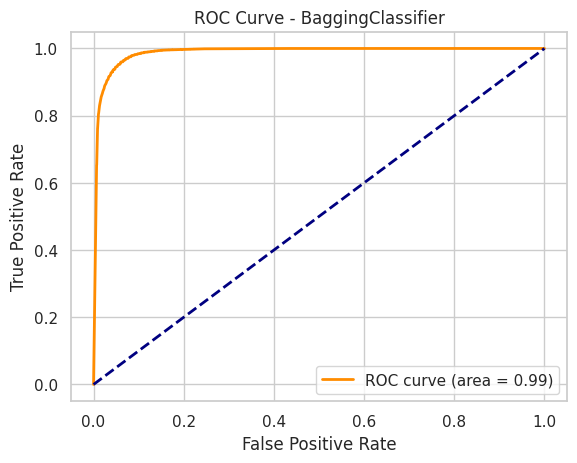

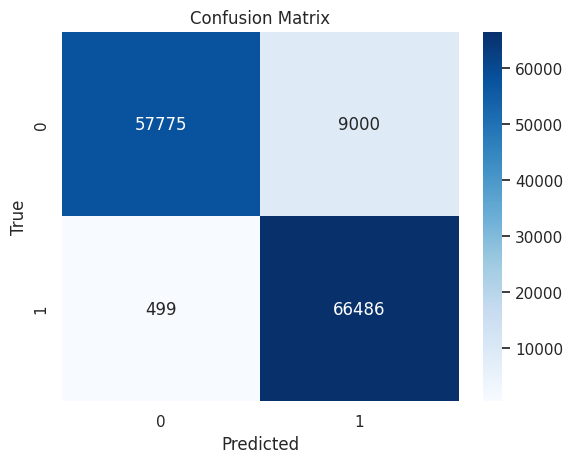

Accuracy using BaggingClassifier: 0.929
F1 Score using BaggingClassifier: 0.929
Log Loss using BaggingClassifier: 0.272
AUC using BaggingClassifier: 0.988
Thời gian thực thi: 00:02:09


<ipython-input-67-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '80:20'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.923
- F1 Score using BaggingClassifier: 0.923
- Log Loss using BaggingClassifier: 0.287
- AUC using BaggingClassifier: 0.986
- Thời gian thực thi: 00:02:42

### 3.4.4 Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


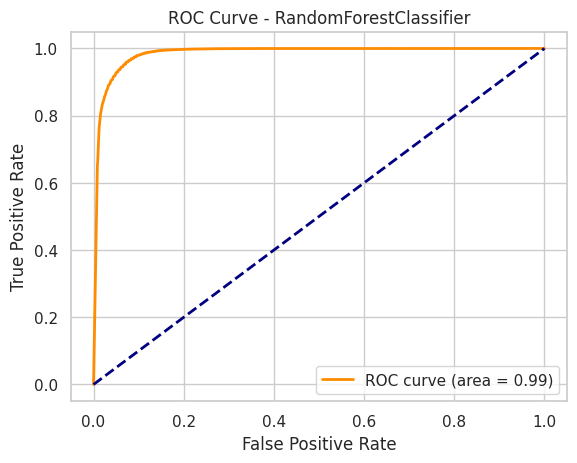

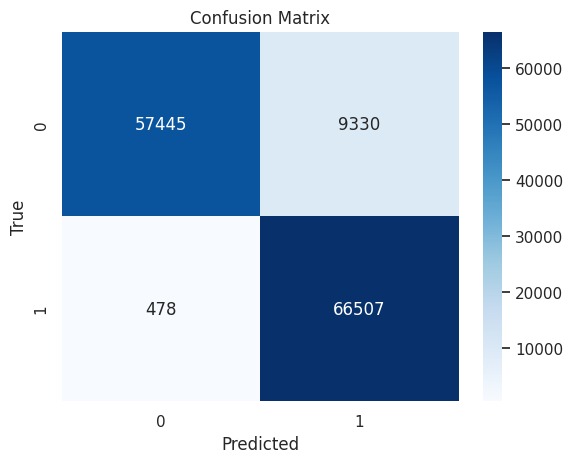

Accuracy using RandomForestClassifier: 0.927
F1 Score using RandomForestClassifier: 0.926
Log Loss using RandomForestClassifier: 0.310
AUC using RandomForestClassifier: 0.985
Thời gian thực thi: 00:00:59


<ipython-input-70-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = "80:20"

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.920
- F1 Score using RandomForestClassifier: 0.920
- Log Loss using RandomForestClassifier: 0.348
- AUC using RandomForestClassifier: 0.982
- Thời gian thực thi: 00:01:01

### 3.4.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


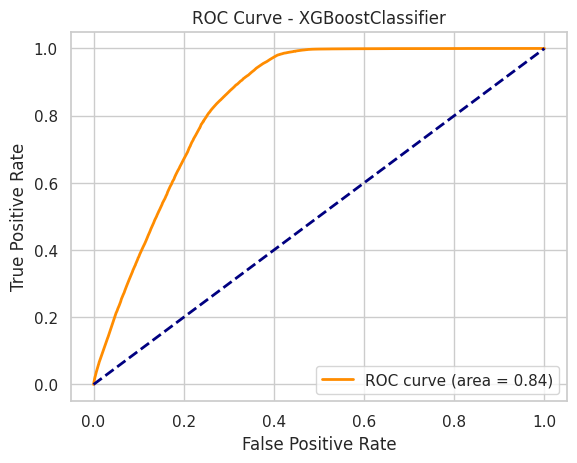

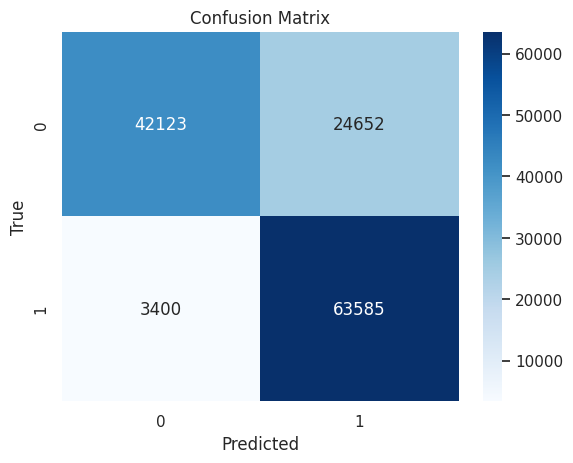

Accuracy using XGBoostClassifier: 0.790
F1 Score using XGBoostClassifier: 0.785
Log Loss using XGBoostClassifier: 0.432
AUC using XGBoostClassifier: 0.844
Thời gian thực thi: 00:00:06


<ipython-input-73-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = "80:20"
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.431
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:05

### 3.4.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results, voting_clf


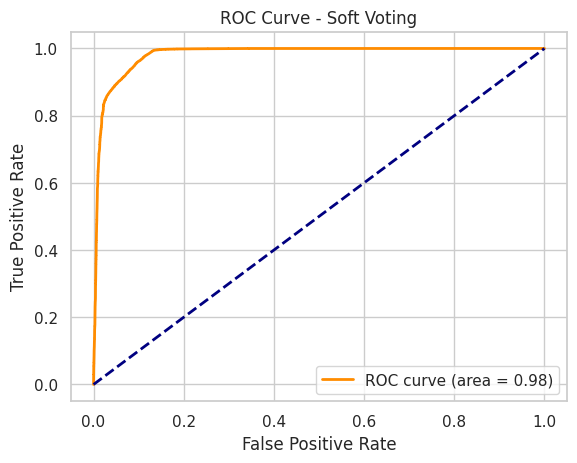

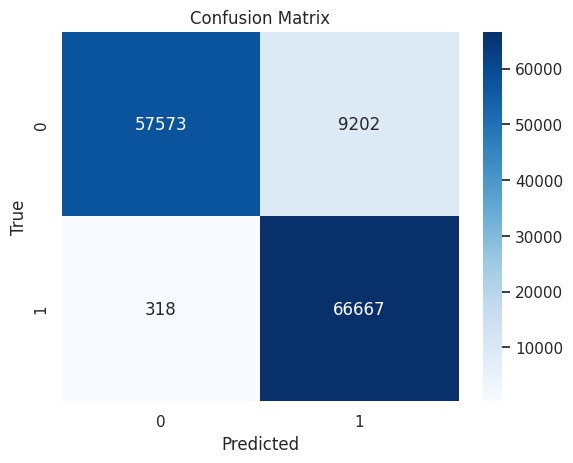

Accuracy using Soft Voting: 0.929
F1 Score using Soft Voting: 0.928
Log Loss using Soft Voting: 0.225
AUC using Soft Voting: 0.982
Thời gian thực thi: 00:02:33


<ipython-input-76-558b688d9b12>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = "80:20"
# Ensure results DataFrame is initialized
results, voting_clf = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.924
- F1 Score using Soft Voting: 0.924
- Log Loss using Soft Voting: 0.231
- AUC using Soft Voting: 0.979
- Thời gian thực thi: 00:02:23

## 3.5 RATIO 85:15

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.15, random_state=42)

### 3.5.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

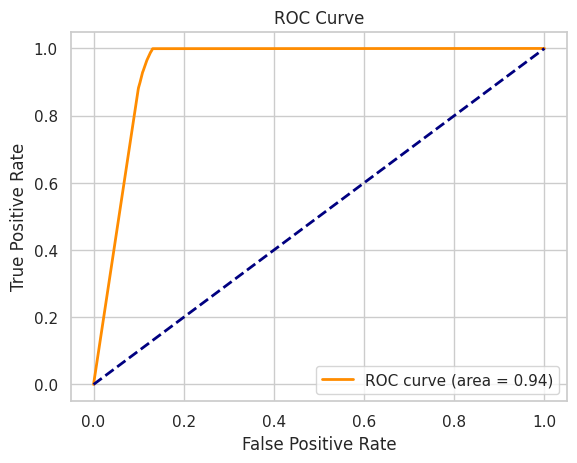

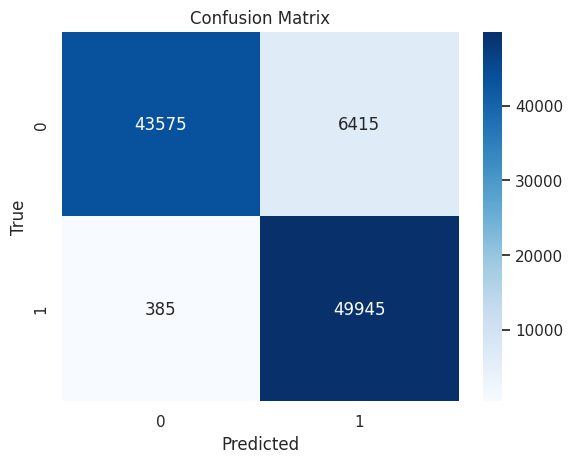

Accuracy: 0.932
F1 Score: 0.932
Log Loss: 1.805
AUC: 0.943
Execution Time: 00:00:05


<ipython-input-82-b7511521f7c9>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results

# Gọi hàm
results = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '85:15', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.931
- F1 Score using DecisionTreeClassifier: 0.931
- Log Loss using DecisionTreeClassifier: 1.885
- AUC using DecisionTreeClassifier: 0.941
- Thời gian thực thi: 00:00:06

### 3.5.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


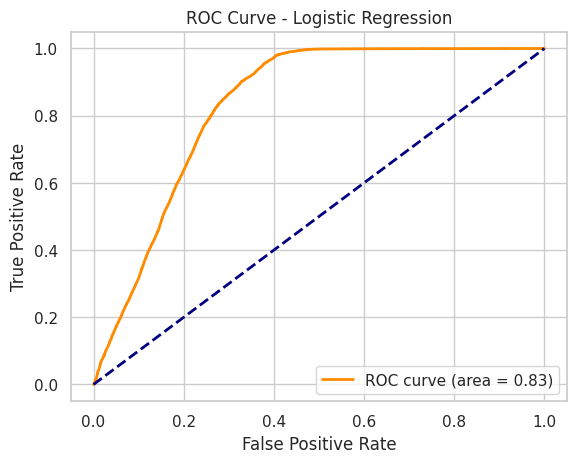

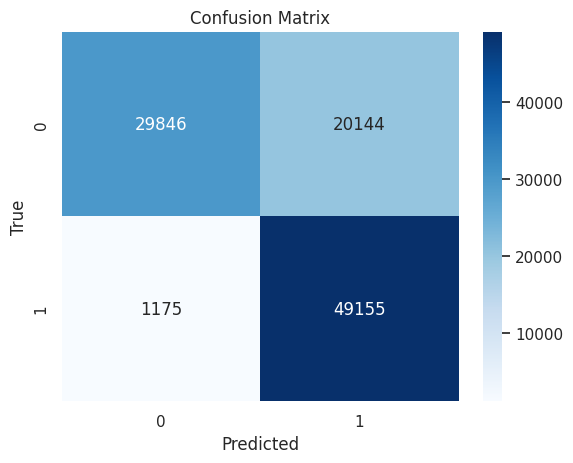

Accuracy using Logistic Regression: 0.787
F1 Score using Logistic Regression: 0.779
Log Loss using Logistic Regression: 0.439
AUC using Logistic Regression: 0.833
Thời gian thực thi: 00:00:05


<ipython-input-84-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '85:15'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.787
- F1 Score using Logistic Regression: 0.781
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.842
- Thời gian thực thi: 00:00:03

### 3.5.3 Bagging Classifier



In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


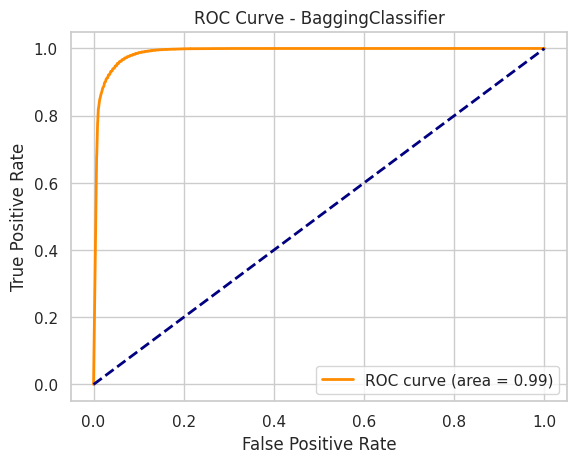

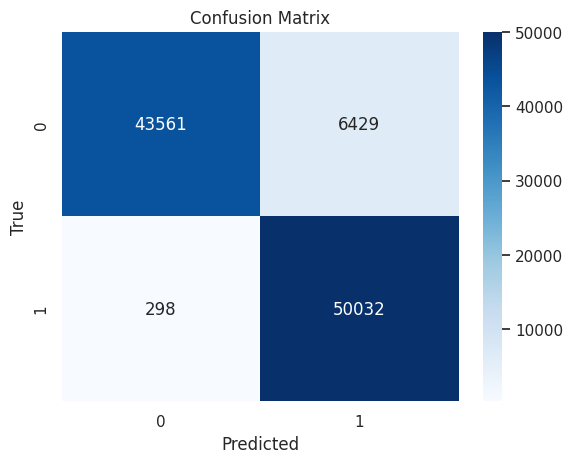

Accuracy using BaggingClassifier: 0.933
F1 Score using BaggingClassifier: 0.933
Log Loss using BaggingClassifier: 0.266
AUC using BaggingClassifier: 0.989
Thời gian thực thi: 00:02:19


<ipython-input-87-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '85:15'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.932
- F1 Score using BaggingClassifier: 0.931
- Log Loss using BaggingClassifier: 0.262
- AUC using BaggingClassifier: 0.989
- Thời gian thực thi: 00:02:52

### 3.5.4. Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


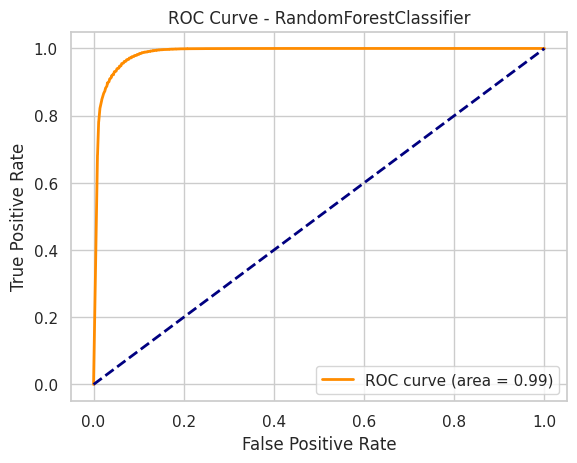

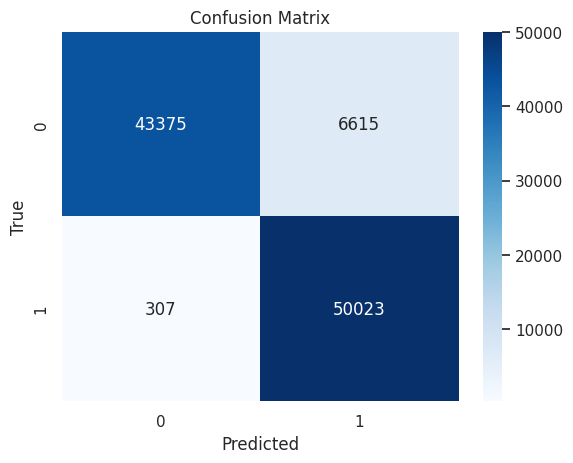

Accuracy using RandomForestClassifier: 0.931
F1 Score using RandomForestClassifier: 0.931
Log Loss using RandomForestClassifier: 0.302
AUC using RandomForestClassifier: 0.987
Thời gian thực thi: 00:01:00


<ipython-input-90-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = "85:15"

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.928
- F1 Score using RandomForestClassifier: 0.928
- Log Loss using RandomForestClassifier: 0.318
- AUC using RandomForestClassifier: 0.985
- Thời gian thực thi: 00:01:05

### 3.5.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


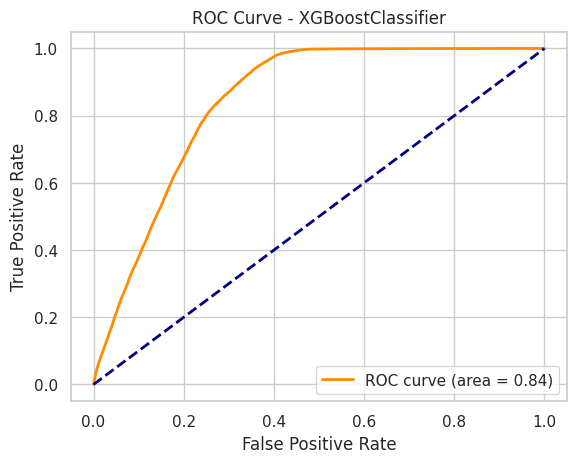

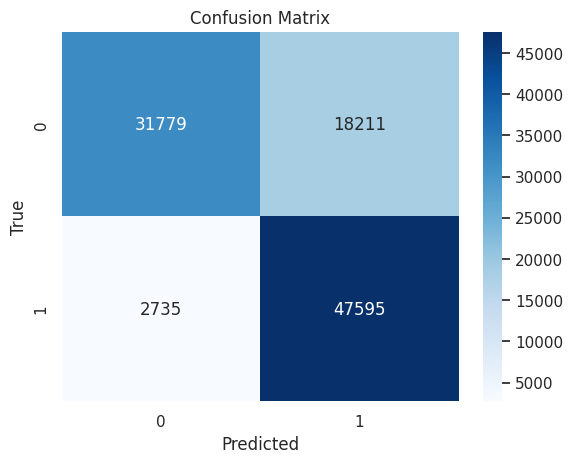

Accuracy using XGBoostClassifier: 0.791
F1 Score using XGBoostClassifier: 0.786
Log Loss using XGBoostClassifier: 0.430
AUC using XGBoostClassifier: 0.845
Thời gian thực thi: 00:00:05


<ipython-input-93-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = "85:15"
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.431
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:06

### 3.5.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


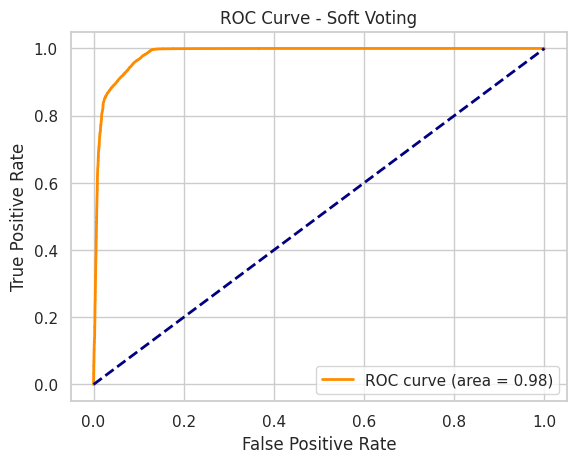

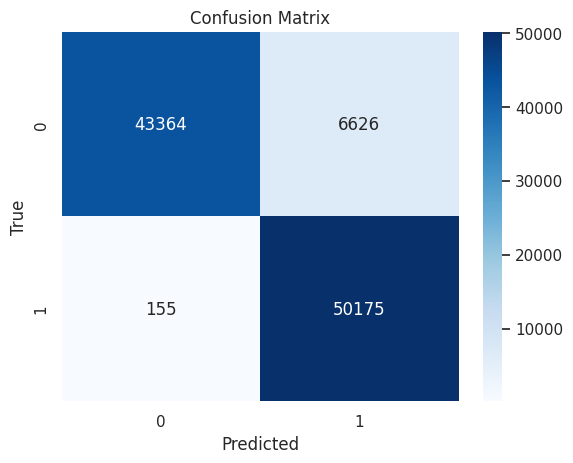

Accuracy using Soft Voting: 0.932
F1 Score using Soft Voting: 0.932
Log Loss using Soft Voting: 0.220
AUC using Soft Voting: 0.983
Thời gian thực thi: 00:02:22


<ipython-input-96-327ea5aea0a5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = "85:15"
# Ensure results DataFrame is initialized
results = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.930
- F1 Score using Soft Voting: 0.930
- Log Loss using Soft Voting: 0.221
- AUC using Soft Voting: 0.982
- Thời gian thực thi: 00:02:50

## 3.6 RATIO 90:10

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.1, random_state=42)

### 3.6.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

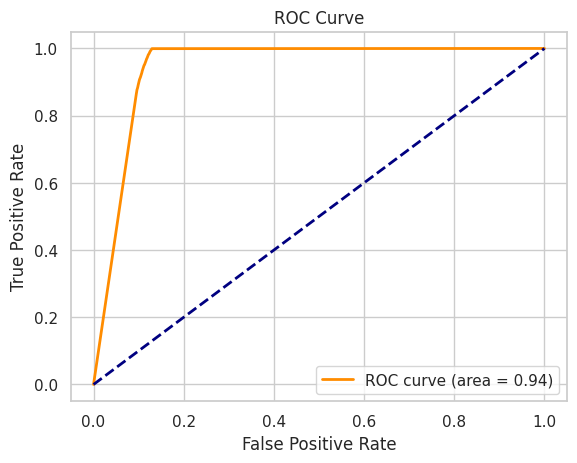

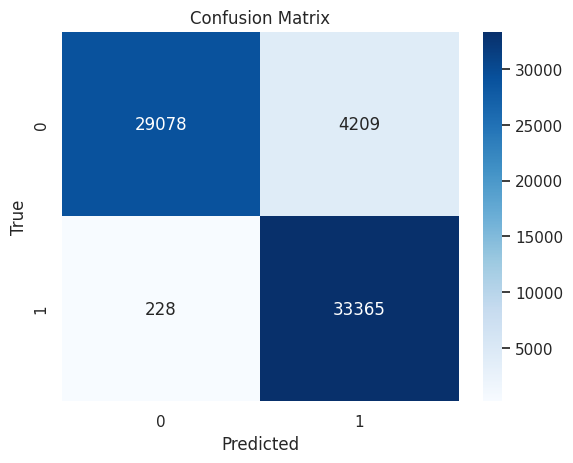

Accuracy: 0.934
F1 Score: 0.933
Log Loss: 1.749
AUC: 0.944
Execution Time: 00:00:04


<ipython-input-102-73c866ed1126>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results

# Gọi hàm
results = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '90:10', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.931
- F1 Score using DecisionTreeClassifier: 0.931
- Log Loss using DecisionTreeClassifier: 1.885
- AUC using DecisionTreeClassifier: 0.941
- Thời gian thực thi: 00:00:06

### 3.6.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


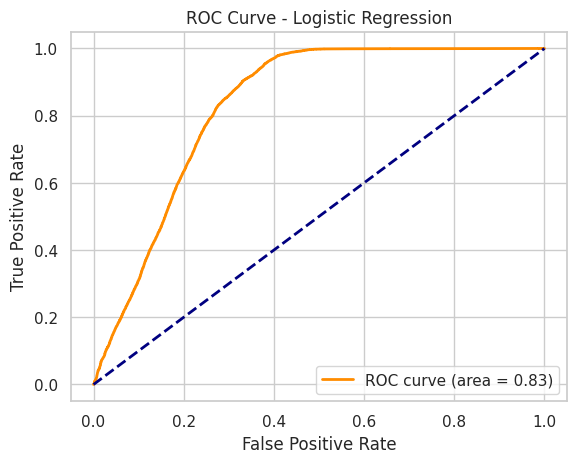

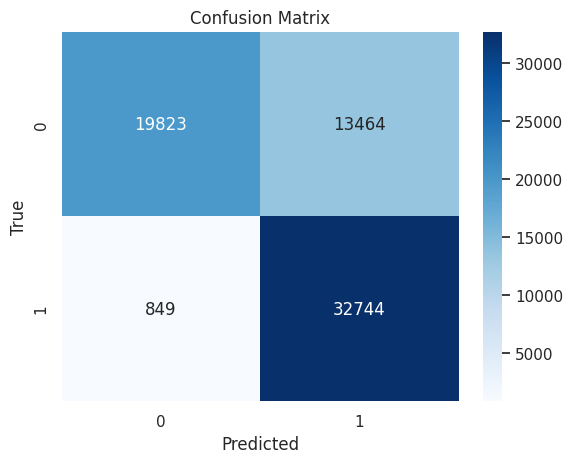

Accuracy using Logistic Regression: 0.786
F1 Score using Logistic Regression: 0.778
Log Loss using Logistic Regression: 0.442
AUC using Logistic Regression: 0.831
Thời gian thực thi: 00:00:10


<ipython-input-104-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '90:10'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.787
- F1 Score using Logistic Regression: 0.781
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.842
- Thời gian thực thi: 00:00:03

### 3.6.3 Bagging Classifier



In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


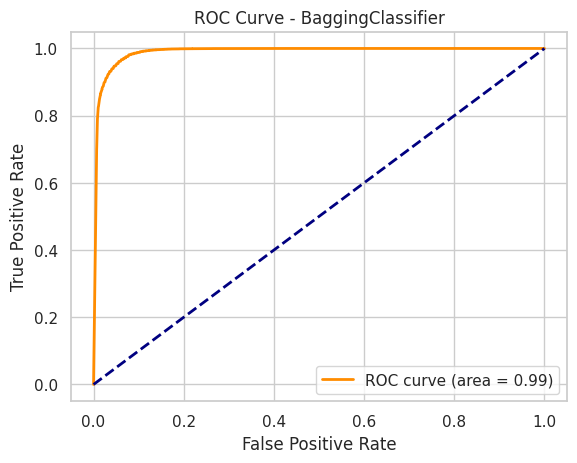

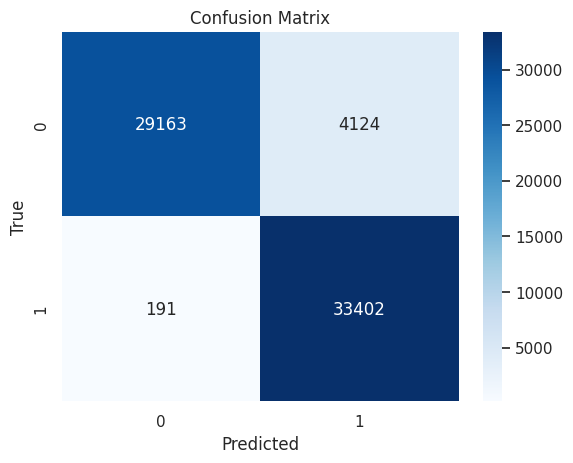

Accuracy using BaggingClassifier: 0.935
F1 Score using BaggingClassifier: 0.935
Log Loss using BaggingClassifier: 0.262
AUC using BaggingClassifier: 0.989
Thời gian thực thi: 00:02:25


<ipython-input-107-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '90:10'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.932
- F1 Score using BaggingClassifier: 0.931
- Log Loss using BaggingClassifier: 0.262
- AUC using BaggingClassifier: 0.989
- Thời gian thực thi: 00:02:52

### 3.6.4. Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


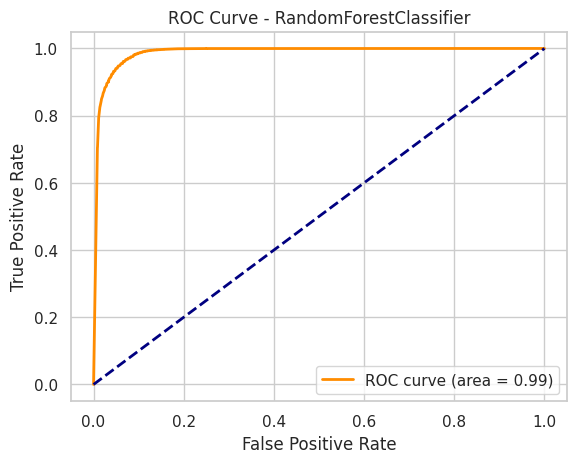

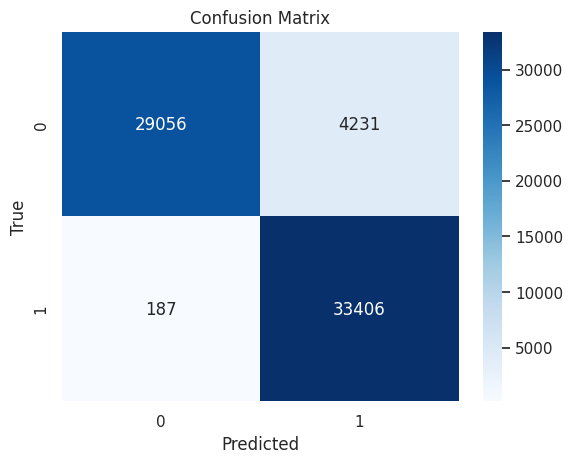

Accuracy using RandomForestClassifier: 0.934
F1 Score using RandomForestClassifier: 0.934
Log Loss using RandomForestClassifier: 0.295
AUC using RandomForestClassifier: 0.987
Thời gian thực thi: 00:01:01


<ipython-input-110-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = '90:10'

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.928
- F1 Score using RandomForestClassifier: 0.928
- Log Loss using RandomForestClassifier: 0.318
- AUC using RandomForestClassifier: 0.985
- Thời gian thực thi: 00:01:05

### 3.6.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


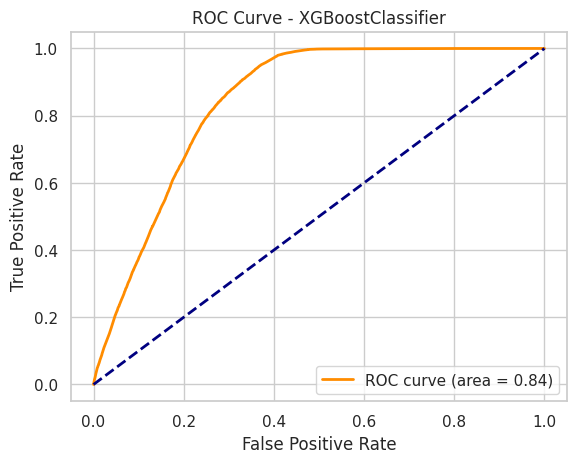

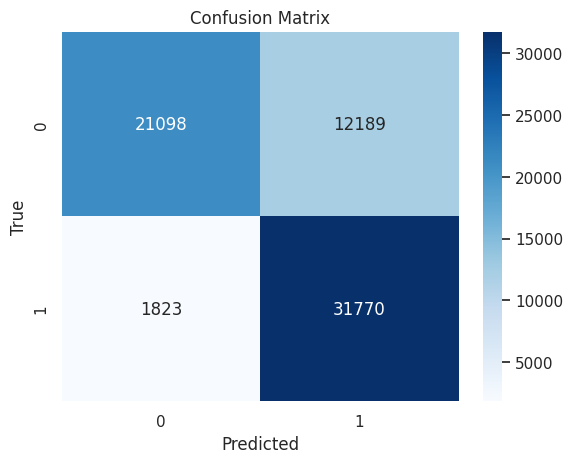

Accuracy using XGBoostClassifier: 0.790
F1 Score using XGBoostClassifier: 0.785
Log Loss using XGBoostClassifier: 0.432
AUC using XGBoostClassifier: 0.843
Thời gian thực thi: 00:00:05


<ipython-input-113-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = '90:10'
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.431
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:06

### 3.6.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results, voting_clf


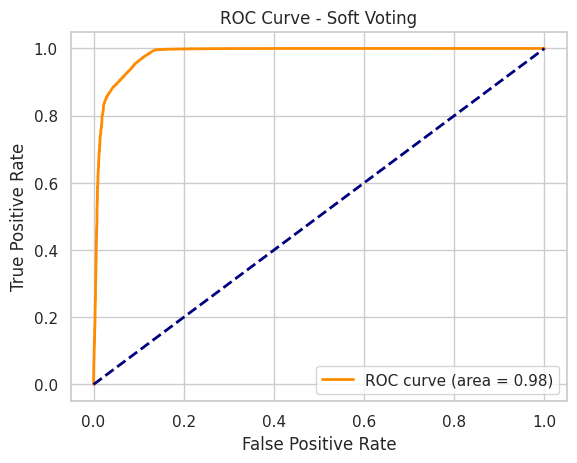

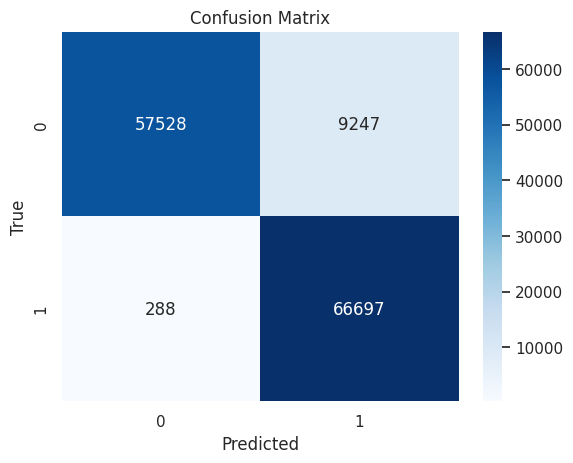

Accuracy using Soft Voting: 0.929
F1 Score using Soft Voting: 0.928
Log Loss using Soft Voting: 0.225
AUC using Soft Voting: 0.982
Thời gian thực thi: 00:02:43


<ipython-input-16-558b688d9b12>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = '90:10'
# Ensure results DataFrame is initialized
results, voting_clf = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.930
- F1 Score using Soft Voting: 0.930
- Log Loss using Soft Voting: 0.221
- AUC using Soft Voting: 0.982
- Thời gian thực thi: 00:02:50

In [ ]:
import pickle

# Giả sử voting_clf là mô hình đã được huấn luyện của bạn
# Lưu mô hình vào file
with open('voting_classifier_model.pkl', 'wb') as file:
    pickle.dump(voting_clf, file)

print("Mô hình đã được lưu thành công.")


Mô hình đã được lưu thành công.


In [ ]:
with open('voting_classifier_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Bây giờ bạn có thể sử dụng loaded_model để dự đoán hoặc kiểm tra


In [ ]:
test_data_org = pd.read_csv('test.csv')
test = test_data_org.copy()

In [ ]:
# Thực hiện dự đoán sử dụng mô hình đã tải
y_pred_new = loaded_model.predict(test)
# Hoặc để lấy xác suất dự đoán (nếu cần):
y_pred_proba_new = loaded_model.predict_proba(test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- id


## 3.7 RATIO 95:05


In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.05, random_state=42)

### 3.7.1 Decision Tree

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

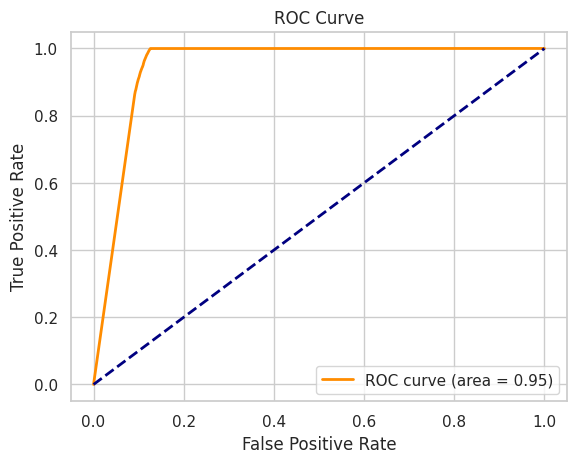

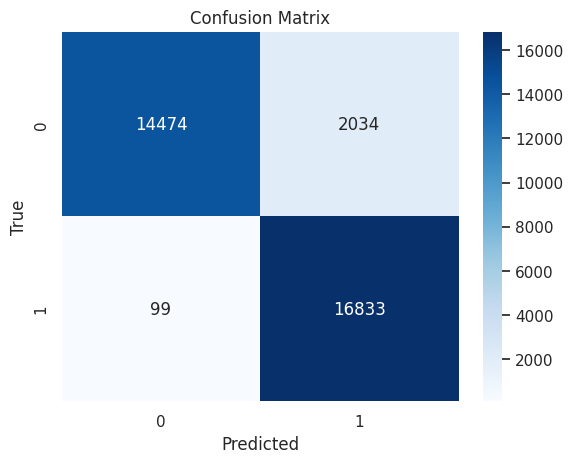

Accuracy: 0.936
F1 Score: 0.936
Log Loss: 1.660
AUC: 0.946
Execution Time: 00:00:05


<ipython-input-122-e277adb1065e>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
def result_DecisionTree(X_train, X_valid, y_train, y_valid, results, model_id, ratio,random_state=42):
    start_time = time.time()

    clf = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=random_state
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(y_valid, y_pred)

    # Trích xuất TN, FP, FN, TP từ confusion matrix
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))

    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy: %.3f' % accuracy)
    print('F1 Score: %.3f' % f1)
    print('Log Loss: %.3f' % log_loss_val)
    print('AUC: %.3f' % auc_score)
    print("Execution Time:", execution_time_formatted)

    # Thêm TN, FP, FN, TP vào DataFrame results
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results

# Gọi hàm
results = result_DecisionTree(X_train_copy, X_valid_copy, y_train_copy, y_valid_copy, results, model_id = 'Decision Tree', ratio = '95:5', random_state=42)

- Accuracy using DecisionTreeClassifier: 0.931
- F1 Score using DecisionTreeClassifier: 0.931
- Log Loss using DecisionTreeClassifier: 1.885
- AUC using DecisionTreeClassifier: 0.941
- Thời gian thực thi: 00:00:06

### 3.7.2 Logistic Regression

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss

def result_LogisticRegression(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=100,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Logistic Regression: %.3f' % accuracy)
    print('F1 Score using Logistic Regression: %.3f' % f1)
    print('Log Loss using Logistic Regression: %.3f' % log_loss_val)
    print('AUC using Logistic Regression: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


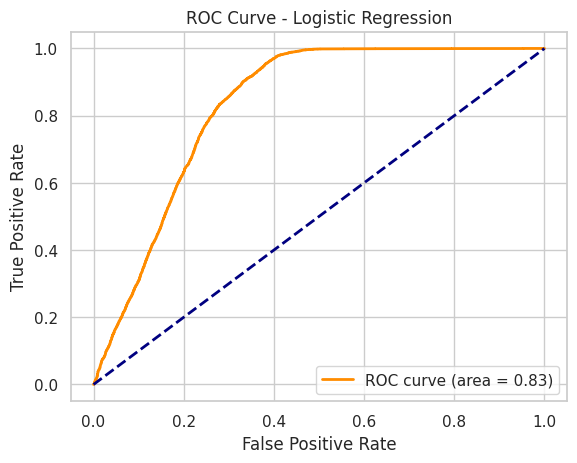

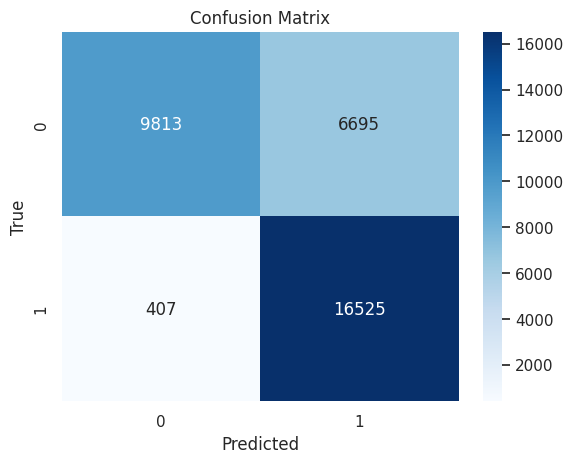

Accuracy using Logistic Regression: 0.788
F1 Score using Logistic Regression: 0.779
Log Loss using Logistic Regression: 0.441
AUC using Logistic Regression: 0.830
Thời gian thực thi: 00:00:06


<ipython-input-124-74a9d9c0a71b>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Ensure you have the necessary libraries and data defined as per previous instructions

# Assuming 'results' DataFrame is initialized and other variables are defined
model_id = 'Logistic Regression'
ratio = '95:5'

# Call the modified function with the dataset and parameters
results = result_LogisticRegression(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)

# Now, 'results' DataFrame should contain the evaluation metrics for the Logistic Regression model


- Accuracy using Logistic Regression: 0.787
- F1 Score using Logistic Regression: 0.781
- Log Loss using Logistic Regression: 0.435
- AUC using Logistic Regression: 0.842
- Thời gian thực thi: 00:00:03

### 3.7.3 Bagging Classifier



In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_BaggingClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = BaggingClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaggingClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print('AUC using BaggingClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


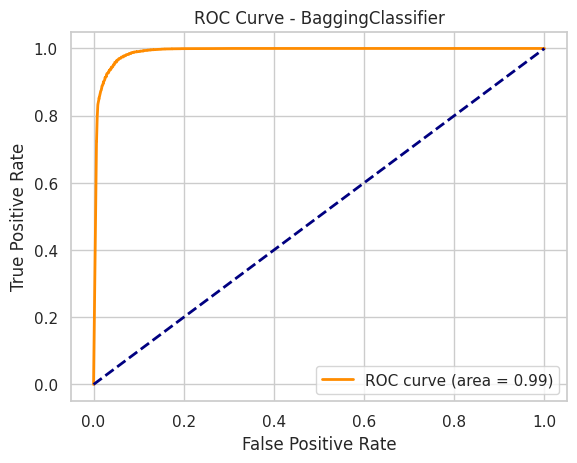

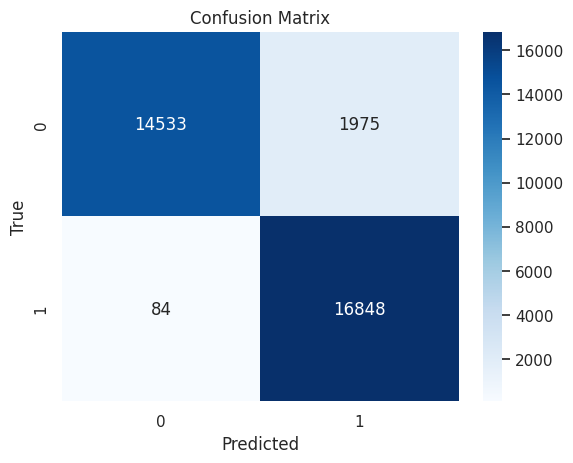

Accuracy using BaggingClassifier: 0.938
F1 Score using BaggingClassifier: 0.938
Log Loss using BaggingClassifier: 0.248
AUC using BaggingClassifier: 0.990
Thời gian thực thi: 00:02:27


<ipython-input-127-01d88a276634>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Call the function with the necessary parameters
model_id = 'Bagging Classifier'
ratio = '95:5'  # Assuming this is your train-test split ratio

results = result_BaggingClassifier(
    X_train_copy,
    y_train_copy,
    X_valid_copy,
    y_valid_copy,
    results,
    model_id,
    ratio
)

# Now, `results` will contain the evaluation metrics for the Bagging Classifier model as well


- Accuracy using BaggingClassifier: 0.932
- F1 Score using BaggingClassifier: 0.931
- Log Loss using BaggingClassifier: 0.262
- AUC using BaggingClassifier: 0.989
- Thời gian thực thi: 00:02:52

### 3.7.4. Random Forest

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_RandomForestClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForestClassifier')
    plt.legend(loc='lower right')
    plt.show()

    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred)
    TN, FP, FN, TP = cm.ravel()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, clf.predict_proba(X_valid))
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using RandomForestClassifier: %.3f' % accuracy)
    print('F1 Score using RandomForestClassifier: %.3f' % f1)
    print('Log Loss using RandomForestClassifier: %.3f' % log_loss_val)
    print('AUC using RandomForestClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': log_loss_val,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


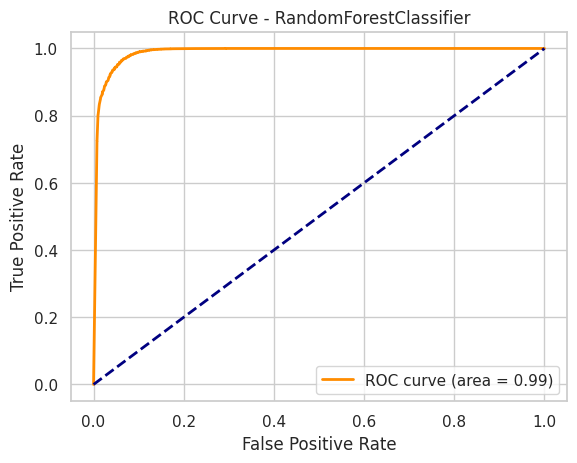

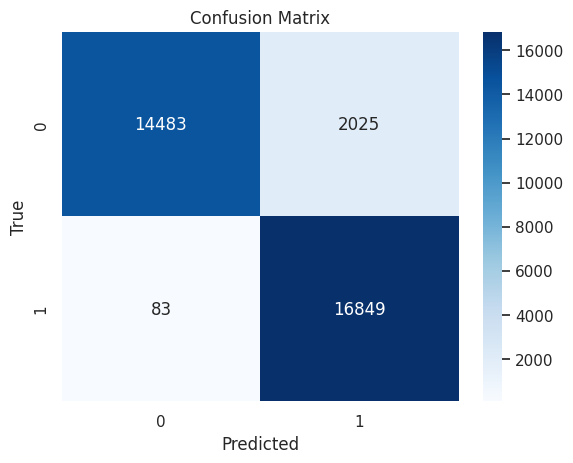

Accuracy using RandomForestClassifier: 0.937
F1 Score using RandomForestClassifier: 0.937
Log Loss using RandomForestClassifier: 0.271
AUC using RandomForestClassifier: 0.989
Thời gian thực thi: 00:01:08


<ipython-input-130-2f07666aa62b>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Assuming results DataFrame is initialized and model_id and ratio are defined as follows:
model_id = "Random Forest"
ratio = '95:5'

# Now, call the function with the data
results = result_RandomForestClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using RandomForestClassifier: 0.928
- F1 Score using RandomForestClassifier: 0.928
- Log Loss using RandomForestClassifier: 0.318
- AUC using RandomForestClassifier: 0.985
- Thời gian thực thi: 00:01:05

### 3.7.5 XGBoost

In [ ]:

# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_XGBoostClassifier(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    clf = xgb.XGBClassifier(
        learning_rate=0.1,
        nthread=-1,
        max_depth=3,
        colsample_bytree=1.0,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    cm = confusion_matrix(y_valid, y_pred)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoostClassifier')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using XGBoostClassifier: %.3f' % accuracy)
    print('F1 Score using XGBoostClassifier: %.3f' % f1)
    print('Log Loss using XGBoostClassifier: %.3f' % logloss)
    print('AUC using XGBoostClassifier: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


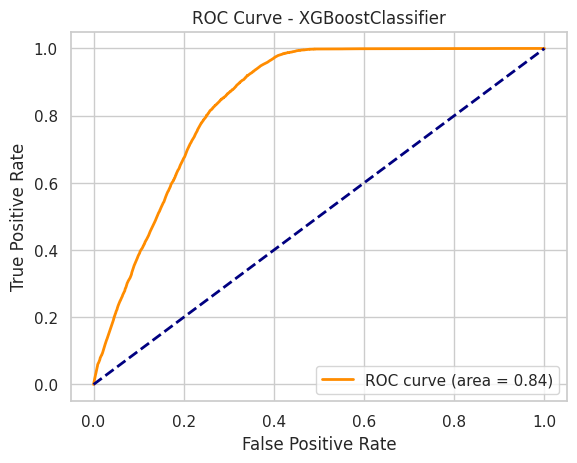

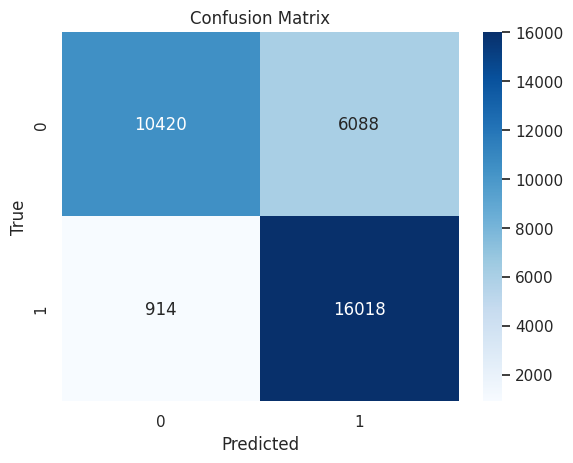

Accuracy using XGBoostClassifier: 0.791
F1 Score using XGBoostClassifier: 0.785
Log Loss using XGBoostClassifier: 0.431
AUC using XGBoostClassifier: 0.844
Thời gian thực thi: 00:00:04


<ipython-input-133-76f5f67f5f26>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
# Example call (ensure all variables are initialized appropriately)
model_id = "XGBoost"
ratio = '95:5'
results = result_XGBoostClassifier(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using XGBoostClassifier: 0.790
- F1 Score using XGBoostClassifier: 0.785
- Log Loss using XGBoostClassifier: 0.431
- AUC using XGBoostClassifier: 0.845
- Thời gian thực thi: 00:00:06

### 3.7.6 Voting Classifier

In [ ]:
# Checkpoint
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
#READY TO USE :)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def result_SoftVoting(X_train, y_train, X_valid, y_valid, results, model_id, ratio):
    start_time = time.time()

    decision_tree = DecisionTreeClassifier(random_state=42)
    logistic_regression = LogisticRegression(max_iter=100)
    bagging_classifier = BaggingClassifier(n_estimators=50, random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('dt', decision_tree), ('lr', logistic_regression), ('bagging', bagging_classifier)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)

    y_pred_proba = voting_clf.predict_proba(X_valid)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    logloss = log_loss(y_valid, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:, 1])
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Soft Voting')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_valid, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    execution_time_formatted = time.strftime("%H:%M:%S", time.gmtime(execution_time))

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print('AUC using Soft Voting: %.3f' % auc_score)
    print("Thời gian thực thi:", execution_time_formatted)

    TN, FP, FN, TP = cm.ravel()
    results = results.append({
        'Model': model_id,
        'Ratio': ratio,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Log Loss': logloss,
        'AUC': auc_score,
        'Execution Time': execution_time_formatted,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }, ignore_index=True)

    return results


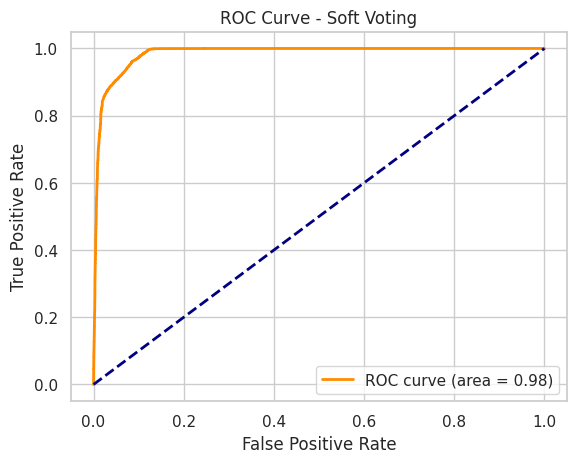

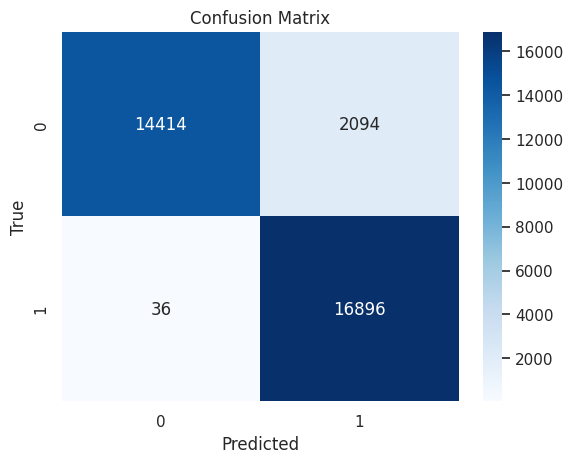

Accuracy using Soft Voting: 0.936
F1 Score using Soft Voting: 0.936
Log Loss using Soft Voting: 0.214
AUC using Soft Voting: 0.985
Thời gian thực thi: 00:02:46


<ipython-input-136-327ea5aea0a5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [ ]:
model_id = "Soft Voting"
ratio = '95:5'
# Ensure results DataFrame is initialized
results = result_SoftVoting(X_train_copy, y_train_copy, X_valid_copy, y_valid_copy, results, model_id, ratio)


- Accuracy using Soft Voting: 0.930
- F1 Score using Soft Voting: 0.930
- Log Loss using Soft Voting: 0.221
- AUC using Soft Voting: 0.982
- Thời gian thực thi: 00:02:50

# IV. RESULT TABLE

In [ ]:
results

,Model,Ratio,Accuracy,F1 Score,Log Loss,AUC,TN,FP,FN,TP,Execution Time
0,Decision Tree,50:50,0.903089,0.902618,2.830247,0.913175,139375,27689,4718,162617,00:00:03
1,Logistic Regression,50:50,0.785271,0.777087,0.441619,0.831491,99260,67804,4001,163334,00:00:08
2,Bagging Classifier,50:50,0.898872,0.898230,0.336701,0.974596,137010,30054,3763,163572,00:02:23
3,Random Forest,50:50,0.897703,0.897044,0.389448,0.970036,136721,30343,3865,163470,00:00:53
4,XGBoost,50:50,0.789443,0.783936,0.432253,0.842765,105301,61763,8647,158688,00:00:03
5,Soft Voting,50:50,0.903729,0.903132,0.264462,0.968350,137979,29085,3108,164227,00:01:37
6,Decision Tree,70:30,0.922862,0.922531,2.119707,0.933508,86023,14113,1364,99140,00:00:04
7,Logistic Regression,70:30,0.785766,0.777634,0.441000,0.831742,59644,40492,2492,98012,00:00:06
8,Bagging Classifier,70:30,0.921606,0.921225,0.291795,0.985323,85478,14658,1071,99433,00:02:03
9,Random Forest,70:30,0.919283,0.918864,0.328988,0.982271,85015,15121,1074,99430,00:00:58


In [ ]:
results.to_csv('results.csv', index=False)

In [ ]:
# Bước 1: Tải dữ liệu
result_data_org = pd.read_csv('results (4).csv')
result = result_data_org.copy()
result

,Model,Ratio,Accuracy,F1 Score,Log Loss,AUC,TN,FP,FN,TP,Execution Time
0,Decision Tree,50-50,0.903089,0.902618,2.830247,0.913175,139375,27689,4718,162617,0:00:03
1,Logistic Regression,50-50,0.785271,0.777087,0.441619,0.831491,99260,67804,4001,163334,0:00:08
2,Bagging Classifier,50-50,0.898872,0.898230,0.336701,0.974596,137010,30054,3763,163572,0:02:23
3,Random Forest,50-50,0.897703,0.897044,0.389448,0.970036,136721,30343,3865,163470,0:00:53
4,XGBoost,50-50,0.789443,0.783936,0.432253,0.842765,105301,61763,8647,158688,0:00:03
5,Soft Voting,50-50,0.903729,0.903132,0.264462,0.968350,137979,29085,3108,164227,0:01:37
6,Decision Tree,70-30,0.922862,0.922531,2.119707,0.933508,86023,14113,1364,99140,0:00:04
7,Logistic Regression,70-30,0.785766,0.777634,0.441000,0.831742,59644,40492,2492,98012,0:00:06
8,Bagging Classifier,70-30,0.921606,0.921225,0.291795,0.985323,85478,14658,1071,99433,0:02:03
9,Random Forest,70-30,0.919283,0.918864,0.328988,0.982271,85015,15121,1074,99430,0:00:58


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Model           36 non-null     object 
 1   Ratio           36 non-null     object 
 2   Accuracy        36 non-null     float64
 3   F1 Score        36 non-null     float64
 4   Log Loss        36 non-null     float64
 5   AUC             36 non-null     float64
 6   TN              36 non-null     int64  
 7   FP              36 non-null     int64  
 8   FN              36 non-null     int64  
 9   TP              36 non-null     int64  
 10  Execution Time  36 non-null     object 
dtypes: float64(4), int64(4), object(3)
memory usage: 3.2+ KB


In [ ]:
result.describe()

,Accuracy,F1 Score,Log Loss,AUC,TN,FP,FN,TP
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.879931,0.877377,0.618498,0.926896,55663.083333,16630.250000,1584.111111,71029.055556
std,0.066472,0.069609,0.658311,0.066610,39096.332037,15882.980775,1925.520824,49074.574258
min,0.785271,0.777087,0.213989,0.830467,9813.000000,1975.000000,36.000000,16018.000000
25%,0.790438,0.784698,0.269635,0.843507,29031.250000,6333.250000,280.500000,33392.750000
50%,0.922234,0.921878,0.409595,0.957230,43468.000000,10759.500000,776.000000,56880.000000
75%,0.932541,0.932236,0.441106,0.984940,85130.750000,25238.000000,2552.750000,99212.500000
max,0.938427,0.938131,2.830247,0.990446,139375.000000,67804.000000,8647.000000,164227.000000


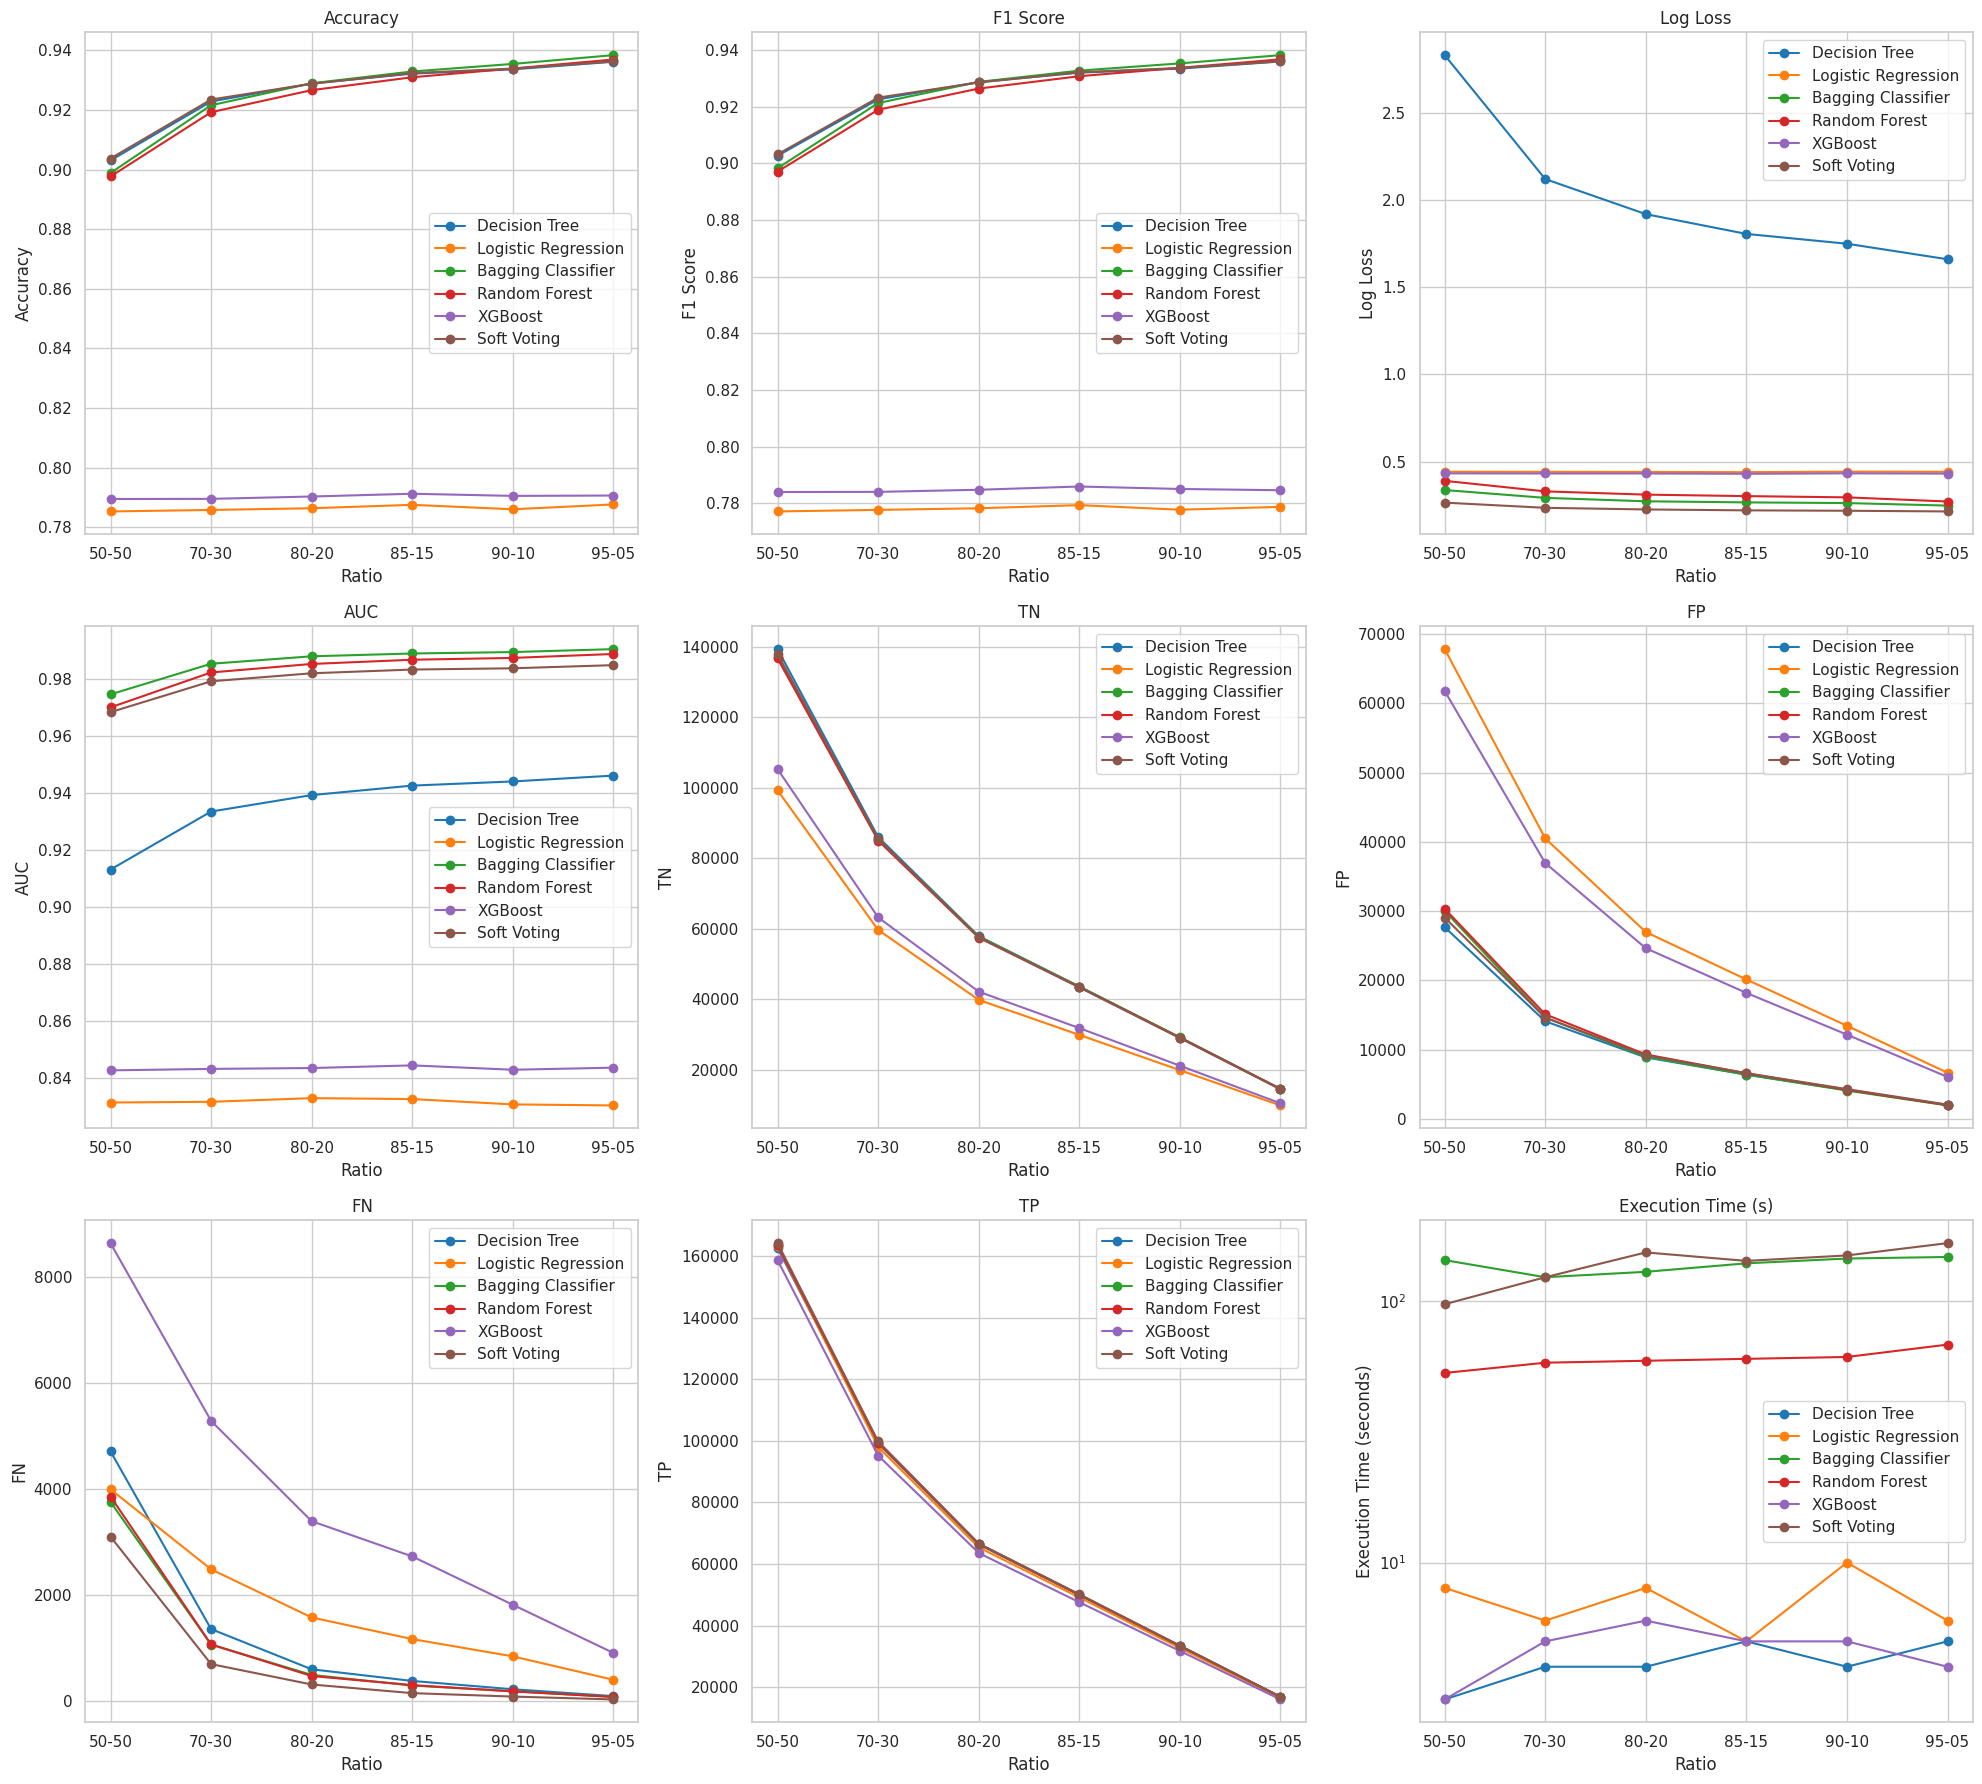

In [ ]:
# Create a large subplot grid for all 9 metrics again
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()  # Flatten to make it easier to iterate

result['Execution Time (s)'] = result['Execution Time'].apply(lambda x: int(x.split(':')[1]) * 60 + int(x.split(':')[2]))
all_metrics = ['Accuracy', 'F1 Score', 'Log Loss', 'AUC', 'TN', 'FP', 'FN', 'TP', 'Execution Time (s)']

# Define a colormap to use for different models
colors = plt.cm.tab10.colors  # This colormap provides 10 distinct colors

# Get unique models for assigning colors
models = result['Model'].unique()
color_map = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Plot each metric with assigned colors for models
for i, metric in enumerate(all_metrics):
    ax = axes[i]
    for model in models:
        subset = result[result['Model'] == model]
        ax.plot(subset['Ratio'], subset[metric], marker='o', label=model, color=color_map[model])
    ax.set_title(metric)
    ax.set_xlabel('Ratio')
    ax.set_ylabel(metric if metric != 'Execution Time (s)' else 'Execution Time (seconds)')
    ax.legend()
    if metric == 'Execution Time (s)':
        ax.set_yscale('log')  # Use log scale for execution time due to wide range of values

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()
